In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

In [2]:
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *

using z-bin None norm 65.75020607931236
using z-bin [0, 0.5, 0.03] norm 14.32276056640902
using z-bin [0.5, 0.5, 0.03] norm 23.943209238913052
using z-bin [1.0, 1.0, 0.04] norm 21.63232752061847
using z-bin [2.0, 1.0, 0.05] norm 3.7179104375669816
using z-bin [3.0, 1.0, 0.05] norm 1.471852539963635


# Lowest order $C_L$s without Limber approximaton 

### 1) $C_L^{\phi\phi}$



In [3]:
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))


r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

n=0

begin=time.time()

chi1fac0 = (lensing_kernel(r2d*chi_cmb, chi_cmb)*D_chi(r2d*chi_cmb))
chi1fac0 = chi1fac0 *(r2d*chi_cmb)**(1-nu_n_.reshape(1, 1, -1))

chi2fac00 = (lensing_kernel(t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*t2d*chi_cmb))
chi2fac01 = (lensing_kernel(1./t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*1./t2d*chi_cmb))
chi2fac01 = chi2fac01 * t2d**(n+nu_n_.reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I0_ltrc[ii])

Clpp  = 2**2*chi_cmb * result*1./np.pi**2/2.*prefac**2/4. #factor 2 for every phi = -2 int W psi
#factor of 1/2 for every gaussian quadrature

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.4057586193084717


In [4]:
# loading CLASS results for comparison
ll,clpp = np.load('../output/clpp_class_no_limber.npy')

(2, 2000)

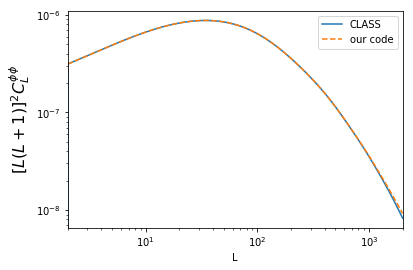

In [5]:
plt.loglog(ll,(ll*(ll+1))**2*clpp, label='CLASS')
plt.loglog(ell_,(ell_*(ell_+1))**2*Clpp,ls='--',label='our code')
plt.legend()
plt.ylabel('$[L(L+1)]^2 C_L^{\phi\phi}$',fontsize=16)
plt.xlabel('L')
plt.xlim(2,2000)

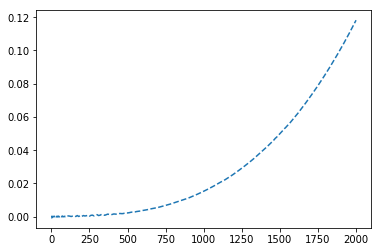

In [6]:

plt.plot(ell_,Clpp/np.interp(ell_,ll,clpp)-1,ls='--',label='ratio to class')

In [7]:
mean = 3.
width = 0.5

# uncomment to run new combinations of mean and variance
# so far we have 3, 0.5 and 1, 0.2

# from classy import Class
# cosmo = Class()


# #cosmo_dict.pop('z_cmb')
# cosmo_dict['output']='nCl, lCl, tCl, sCl, mPk'
# cosmo_dict['lensing']='yes'
# cosmo_dict['selection']='gaussian'
# cosmo_dict['selection']='gaussian'
# cosmo_dict['selection_mean'] = str(mean)
# cosmo_dict['selection_width'] = str(width)
# cosmo_dict['l_switch_limber']=100
# cosmo_dict['perturb_sampling_stepsize']=0.01
# cosmo_dict['P_k_max_1/Mpc']=10.

# cosmo.empty()
# cosmo.set(cosmo_dict)
# cosmo.compute()

# cldd = cosmo.density_cl(300)
# clgg = cldd['dd'][0]
# ll_  = cldd['ell']
# np.save('../output/class_clgg_no_limber_Gauss_mean%d_width%0.e.npy'%(mean,width),[ll_,clgg])

In [8]:

ll_,clgg = np.load('../output/class_clgg_no_limber_Gauss_mean%d_width%0.e.npy'%(mean,width))
print('loaded ','../output/class_clgg_post_limber_Gauss_mean%d_width%0.e.npy'%(mean,width))


loaded  ../output/class_clgg_post_limber_Gauss_mean3_width5e-01.npy


### 2) $C_L^{gg}$

In [9]:
# first let's define different redshift kernels

# 1) general kernel if dNdz is Gaussian
def Gauss_redshift(z0,sigma_z):
    def z_kernel(z):
        return 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-z0)**2/2./sigma_z**2)
    return z_kernel

def gal_kernel(z_kernel,ximax=5):
    def chi_kernel(xi):
        return z_kernel(z_chi(xi))*dz_dchi(xi)
    return chi_kernel


# 2) prospective LSST kernels
def dNdz_LSST(bin_num,dn_filename = '../LSSTdndzs/dndz_LSST_i27_SN5_3y'):
    if bin_num is "all":
        zbin, nbin = np.load(dn_filename+'tot_extrapolated.npy',encoding='latin1')
        norm                = np.trapz(nbin,zbin)
        mbin                = 'None'
    else:
        bins,big_grid,res   = np.load(dn_filename+'_extrapolated.npy',encoding='latin1')
        mbin                = bins[bin_num]
        zbin                = big_grid
        nbin                = res[bin_num]
        norm                = np.trapz(nbin,zbin)
    dndz                = interp1d(zbin, nbin/norm, kind='linear',bounds_error=False,fill_value=0.)
    print('using z-bin', mbin, 'norm', norm)
    return dndz



def gal_clus(dNdz,b,bin_num):
    """
    dNdz: function returning function dndz for gicen bin number 
    b: function returning bias as function of z 
    bin_num: bin_number (either 'all' or 0-5)
    """
    p_z=dNdz(bin_num)
    def kernel(x):
        z = z_chi(x)
        return b(z)*p_z(z)*dz_dchi(z)

    return kernel

def simple_bias(z):
    return (1.+z)

def constant_bias(z,b=1.):
    return b

In [10]:
#Gaussian test case and comparison to class result
begin=time.time()
kernel1 = gal_kernel(Gauss_redshift(mean,width))
kernel2 = gal_kernel(Gauss_redshift(mean,width))

chimax = chi_cmb
n = 4
chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Clgg = chimax * result/np.pi**2/2./4. #dividing by extra factor of 4 (should be there because of Gaussian Quadrature)

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.5716936588287354


(2, 300)

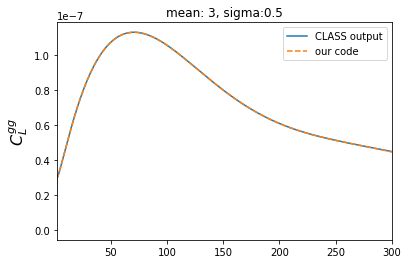

In [11]:
plt.plot(ll_,clgg,label ='CLASS output')
plt.plot(ell_,Clgg,ls='--', label='our code')
plt.legend()
plt.ylabel('$C_L^{gg}$',fontsize=16)
plt.title('mean: %d, sigma:%.1f'%(mean,width))
plt.xlim(2,300)

In [12]:
# now let's use LSST kernels
binnum1= 0
binnum2= 'all'
begin=time.time()
kernel1 = gal_clus(dNdz_LSST,constant_bias,binnum1)
kernel2 = gal_clus(dNdz_LSST,constant_bias,binnum2)

chimax = chi_cmb

n = 4

chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Clgg = chimax * result/np.pi**2/2./4. #dividing by extra factor of 4 (should be there because of Gaussian Quadrature)

print('Time taken = ', time.time()-begin)

using z-bin [0, 0.5, 0.03] norm 14.32276056640902
using z-bin None norm 65.75020607931236


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.4379279613494873


(2, 300)

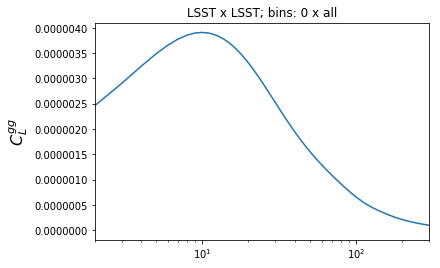

In [13]:
plt.title('LSST x LSST; bins: %s x %s'%(str(binnum1),str(binnum2)))
plt.plot(ell_,Clgg)
plt.ylabel('$C_L^{gg}$',fontsize=16)
plt.xscale('log')
plt.xlim(2,300)

### 3) $C_L^{\phi g}$

In [14]:
# set up (as before), but using FFTlog of P_deltapsi

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

# chimax and kernels
chimax   = chi_cmb

kernel1  = lensing_kernel
kernel2  = gal_kernel(Gauss_redshift(mean,width))

n = 2

begin=time.time()

chi1fac0 = (kernel1(r2d*chimax,chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I2_ltrc[ii])
    

Cl_pg = chimax * result*1./np.pi**2/2.*prefac/4.*2

print('Time taken = ', time.time()-begin)

np.save('../output/Clpg_mean%d_width%0.e.npy'%(mean,width),[ell_,Cl_pg])

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.449406385421753


In [15]:
#making kappa out of phi
Cl_kp = 1/2.*ell_**2*Cl_pg

In [16]:
# cross in Limber, uncomment if you need different kernels than are saved
# chis = np.linspace(1.,chi_cmb,5000) #in Mpc/h
# ells = np.linspace(1,2000,200)
# result=[]
# for l_ in ells:
#     integrand=[]
#     for chi in chis:
#         k = l_/chi #in h/Mpc
#         try:
#             Pk= cosmo.pk(k*h,0.)*D_chi(chi)**2*h**3
#         except:
#             Pk= 0.
#         integrand+=[lensing_kernel(chi,chi_cmb)*kernel2(chi)*Pk]
#     result+=[np.trapz(integrand, chis)]
# clkg=np.asarray(result)*prefac

# np.save('../output/limber_flat_sky_clkg_mean%d_width%0.e.npy'%(mean,width),[ells,clkg])

In [17]:
ells,clkg = np.load('../output/limber_flat_sky_clkg_mean%d_width%0.e.npy'%(mean,width))

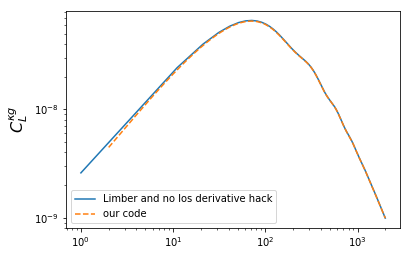

In [18]:
# difference at low ell is expected because I'm comparing to no-Limber
plt.loglog(ells,clkg, label = 'Limber and no los derivative hack')
plt.loglog(ell_,Cl_kp,ls = '--',label='our code')
plt.ylabel('$C_L^{\kappa g}$',fontsize=16)
plt.legend()

### In this last part let's compare the two ways to calculate $C_L^{\kappa\kappa}$: by integrating over $P^{\psi\psi}$ or by integrating over $P^{\kappa\kappa}$ and assuming LOS derivative dont contribute significantly. The latter should be wrong on large scales with a similar scale dependence to the Limber approximation


In [19]:
# clkk from integrating over psi (reusing result from above)

#full sky
clkk1 = 1./4.*(ell_*(ell_+1.))**2*Clpp

#flat sky
clkk2 = 1./4.*(ell_)**4*Clpp

In [20]:
# clkk from integrating over delta

#note the different lensing kernel
def lensing_kernel_2(xi, xmax):
    return (xmax - xi)/(xmax)*xi* (xmax > xi) * (1.+z_chi(xi))

kernel = lensing_kernel_2

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
begin=time.time()
#Try different chimax to see how sampling changes things
chimax   = chi_cmb

chi1fac0 = (kernel(r2d*chimax,chi_cmb)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel(t2d*r2d*chimax,chi_cmb)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel(1./t2d*r2d*chimax,chi_cmb)*D_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])
    

clkk3 = chimax * result*1./np.pi**2/2.*prefac**2/4.

clkk4 = (ell_*(ell_+1))**2/(ell_**4)*clkk3

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


In [24]:
from classy import Class
cosmo = Class()
cosmo_dict['output']='lCl, tCl'
cosmo_dict['lensing']='yes'
# cosmo_dict.pop('selection')
# cosmo_dict.pop('selection_mean')
# cosmo_dict.pop('selection_width')
cosmo_dict['l_switch_limber']=1
cosmo_dict['perturb_sampling_stepsize']=0.01
#cosmo_dict.pop('P_k_max_1/Mpc')
cosmo_dict.pop('z_cmb')

cosmo.empty()
cosmo.set(cosmo_dict)
cosmo.compute()
cllen_Limber= cosmo.lensed_cl(2000)

ll   = cllen_Limber['ell']
clppL = cllen_Limber['pp']
clkk5 = 1./4.*(ll*(ll+1))**2*clppL
clkk6 = 1./4.*(ll)**4*clppL

In [ ]:
plt.loglog(ell_,clkk1,color='blue',label='from psi full sky')
plt.loglog(ell_,clkk2,color='green', label='from psi flat sky')
plt.loglog(ell_,clkk3,ls='--', color='red',label= 'from delta flat sky')
plt.loglog(ell_,clkk4,ls='--', color='orange',label= 'from delta full sky')
plt.loglog(ll,clkk5,ls='-.', color='cyan',label= 'full sky Limber')
plt.loglog(ll,clkk6,ls='-.',color = 'maroon',label= 'flat sky Limber')
plt.legend()
plt.ylabel(r'$C_L^{\kappa\kappa}$',fontsize=16)
plt.xlim(2,100)
plt.xlabel('L')
plt.ylim(2e-8,3e-7)

Note how the two approximations: flat sky and neglection of los derivatives nicely compensate... (a very similar thing happens for the Limber approximation)